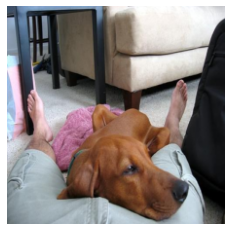

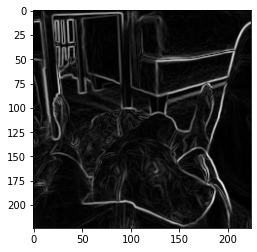

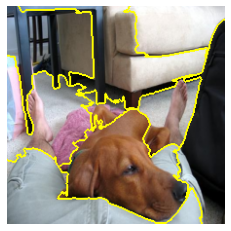

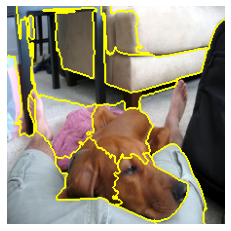

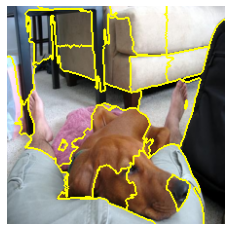

In [7]:
# import the necessary packages
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import torchvision
import torch
import random
import torch.nn as nn
import litdata
from skimage.filters import sobel
from skimage.color import rgb2gray


postprocess = (
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)), 
        #torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    nn.Identity(),
    )

train_dataset = litdata.LITDataset(
            "IN1k",
            r"F:\data",
            override_extensions=[
                'jpg',
                'cls'
            ],
            train = True,
        ).map_tuple(*postprocess)

# Load CIFAR-10 dataset
#train_dataset = torchvision.datasets.CIFAR10(root='F:\data', train=True, download=False, transform=torchvision.transforms.Resize((224, 224)))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Select a random image from the data loader
random_index = 3#random.randint(0, len(train_dataset) - 1)
image_raw, _ = train_dataset[random_index]

# Convert the image to a floating point data type
image = img_as_float(image_raw)

plt.imshow(image)
plt.axis("off")
plt.show()

gradient = sobel(rgb2gray(image))
plt.imshow(gradient, cmap='gray')

# Loop over the number of segments
for numMarkers in (10, 20, 30):
    # Apply Watershed and extract (approximately) the supplied number of segments
    segments_watershed = watershed(gradient, markers=numMarkers, compactness=0.001)
    
    # Show the output of Watershed
    fig = plt.figure("Superpixels -- %d numMarkers" % (numMarkers))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments_watershed))
    plt.axis("off")

# Show the plots
plt.show()

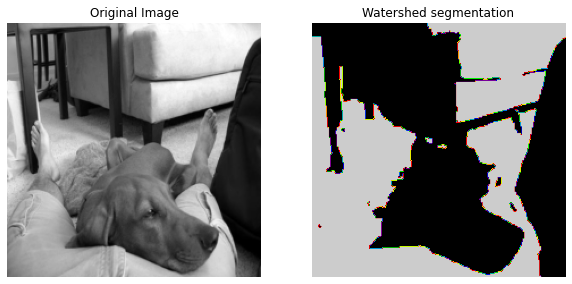

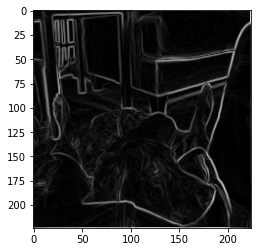

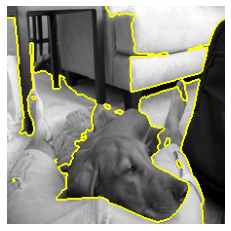

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import data
from skimage.color import rgb2gray
import torch
import torch.nn.functional as F
from collections import deque


def sobel_filter(image):
    # Convert image to a PyTorch tensor and add batch and channel dimensions
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Define Sobel kernels
    Kx = torch.tensor([[-1, 0, 1], 
                       [-2, 0, 2], 
                       [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    Ky = torch.tensor([[ 1,  2,  1], 
                       [ 0,  0,  0], 
                       [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Convolve the image with the Sobel kernels
    Gx = F.conv2d(image, Kx, padding=1)
    Gy = F.conv2d(image, Ky, padding=1)
    
    # Calculate the gradient magnitude
    G = torch.hypot(Gx, Gy)
    
    # Normalize to range [0, 255]
    G = (G / G.max()) * 255
    
    return G.squeeze().detach().numpy().astype(np.uint8)

import numpy as np
from collections import deque
import torch
import torch.nn.functional as F
import heapq

def watershed_from_scratch(image, lower_percentile=30, upper_percentile=70):
    # Convert image to grayscale
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # Compute the gradient magnitude of the image
    gradient = sobel_filter(image)

    # Generate markers based on the given percentiles
    markers = np.zeros_like(image)
    markers[image < np.percentile(image, lower_percentile)] = 1
    markers[image > np.percentile(image, upper_percentile)] = 2

    # Label the markers
    markers_torch = torch.tensor(markers, dtype=torch.int32)
    labeled = torch.zeros_like(markers_torch)
    
    labeled[markers_torch == 1] = 1
    labeled[markers_torch == 2] = 2

    # Simulate flooding process using a priority queue
    heap = []
    for (i, j), value in np.ndenumerate(labeled.numpy()):
        if value > 0:
            heapq.heappush(heap, (gradient[i, j], i, j, value))
    
    while heap:
        h, i, j, label_val = heapq.heappop(heap)
        for di in range(-1, 2):
            for dj in range(-1, 2):
                ni, nj = i + di, j + dj
                if 0 <= ni < gradient.shape[0] and 0 <= nj < gradient.shape[1]:
                    if labeled[ni, nj] == 0:
                        labeled[ni, nj] = label_val
                        heapq.heappush(heap, (gradient[ni, nj], ni, nj, label_val))
    
    # Convert labeled back to numpy for visualization
    labeled = labeled.numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled, cmap='nipy_spectral')
    plt.title('Watershed segmentation')
    plt.axis('off')
    
    plt.show()
    
    plt.imshow(gradient, cmap='gray')
    
    # Show the output of Watershed
    fig = plt.figure("Superpixels -- %d numMarkers" % (numMarkers))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, labeled))
    plt.axis("off")



watershed_from_scratch(image)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
import torch
import torch.nn as nn
import torch.nn.functional as F

def sobel_filter(image):
    # Convert image to a PyTorch tensor and add batch and channel dimensions
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Define Sobel kernels
    Kx = torch.tensor([[-1, 0, 1], 
                       [-2, 0, 2], 
                       [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    Ky = torch.tensor([[ 1,  2,  1], 
                       [ 0,  0,  0], 
                       [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Convolve the image with the Sobel kernels
    Gx = F.conv2d(image, Kx, padding=1)
    Gy = F.conv2d(image, Ky, padding=1)
    
    # Calculate the gradient magnitude
    G = torch.hypot(Gx, Gy)
    
    # Normalize to range [0, 1]
    G = G / G.max()
    
    return G.squeeze(0).squeeze(0)

### 2. Seed Prediction Network

class SeedNet(nn.Module):
    def __init__(self):
        super(SeedNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

### 3. Differentiable Watershed

def differentiable_watershed(image, seed_net):
    # Convert image to grayscale if necessary
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # Compute the gradient magnitude of the image
    gradient = sobel_filter(image)
    
    # Predict seeds using the seed prediction network
    seeds = seed_net(gradient.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
    
    # Soft flooding process
    labeled = torch.zeros_like(gradient)
    height, width = gradient.shape

    for i in range(height):
        for j in range(width):
            if seeds[i, j] > 0.5:
                labeled[i, j] = 1
    
    soft_labels = F.softmax(-gradient.view(-1) / 0.1, dim=0).view(height, width)
    labeled = labeled * soft_labels
    
    return labeled, seeds

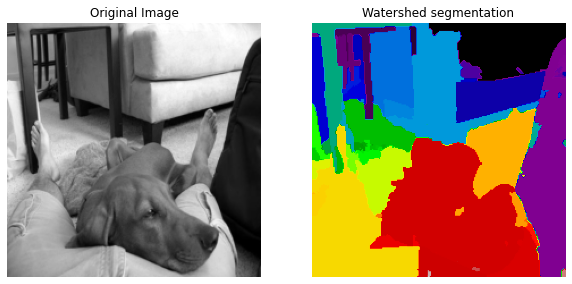

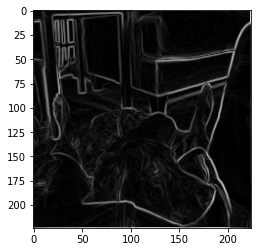

In [3]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import data
from skimage.color import rgb2gray
import torch
import torch.nn.functional as F


def sobel_filter(image):
    """Instead of fixed sobel kernels can we make the parameters in the kernels learnable? This could let the model learn the optimal edge detection filters"""
    # Convert image to a PyTorch tensor and add batch and channel dimensions
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Define Sobel kernels
    Kx = torch.tensor([[-1, 0, 1], 
                       [-2, 0, 2], 
                       [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    Ky = torch.tensor([[ 1,  2,  1], 
                       [ 0,  0,  0], 
                       [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Convolve the image with the Sobel kernels
    Gx = F.conv2d(image, Kx, padding=1)
    Gy = F.conv2d(image, Ky, padding=1)
    
    # Calculate the gradient magnitude
    G = torch.hypot(Gx, Gy)
    
    # Normalize to range [0, 255]
    G = (G / G.max()) * 255
    
    return G.squeeze().detach().numpy().astype(np.uint8)

def generate_binary_structure(rank, connectivity):
    if connectivity < 1:
        connectivity = 1
    if rank < 1:
        return np.array(True, dtype=bool)
    output = np.fabs(np.indices([3] * rank) - 1)
    output = np.add.reduce(output, 0)
    return output <= connectivity

def connected_components(input, structure=None):
    input = np.asarray(input)
    if np.iscomplexobj(input):
        raise TypeError('Complex type not supported')

    if structure is None:
        structure = generate_binary_structure(input.ndim, 1)
    structure = np.asarray(structure, dtype=bool)
    
    if structure.ndim != input.ndim:
        raise RuntimeError('structure and input must have equal rank')
    for ii in structure.shape:
        if ii != 3:
            raise ValueError('structure dimensions must be equal to 3')

    output = np.zeros(input.shape, np.int32)
    label = 1
    max_label = 0

    def flood_fill(x, y, label):
        queue = [(x, y)]
        while queue:
            cx, cy = queue.pop(0)
            if output[cx, cy] == 0 and input[cx, cy]:
                output[cx, cy] = label
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < input.shape[0] and 0 <= ny < input.shape[1]:
                        queue.append((nx, ny))

    for i in range(input.shape[0]):
        for j in range(input.shape[1]):
            if input[i, j] and output[i, j] == 0:
                flood_fill(i, j, label)
                label += 1
                max_label = label - 1

    return output, max_label


def watershed_from_scratch(image):
    # Convert image to grayscale
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # Compute the gradient magnitude of the image
    gradient = sobel_filter(image)

    # Generate markers
    """
    these markers is to identifies specific regions in the image that will serve as starting points (seeds) for the watershed algorithm. In traditional watershed segmentation:
    Low-Intensity Markers (1): These typically correspond to the darker regions in the image, which could represent background or specific objects of interest.
    High-Intensity Markers (2): These typically correspond to the brighter regions in the image, which could represent different objects or features of interest.
    
    By using these markers, the watershed algorithm can "flood" the image from these predefined seed points, allowing for more controlled and accurate segmentation of different regions within the image.
    Instead of using percentiles, could we make the placement of the markers learnable instead?
    """
    markers = np.zeros_like(image)
    markers[image < np.percentile(image, 10)] = 1
    markers[image > np.percentile(image, 90)] = 2

    # Simulate flooding process
    """
    The flooding process inherently involves non-differentiable operations like heap-based priority queues. 
    To make this differentiable, we can approximate the process using differentiable operations, 
    such as softmax for computing probabilities of pixel assignments.
    """
    labeled, _ = connected_components(markers)

    import heapq
    heap = []
    for (i, j), value in np.ndenumerate(labeled):
        if value > 0:
            heapq.heappush(heap, (gradient[i, j], i, j, value))
    
    while heap:
        h, i, j, label_val = heapq.heappop(heap)
        for di in range(-1, 2):
            for dj in range(-1, 2):
                ni, nj = i + di, j + dj
                if 0 <= ni < gradient.shape[0] and 0 <= nj < gradient.shape[1]:
                    if labeled[ni, nj] == 0:
                        labeled[ni, nj] = label_val
                        heapq.heappush(heap, (gradient[ni, nj], ni, nj, label_val))


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled, cmap='nipy_spectral')
    plt.title('Watershed segmentation')
    plt.axis('off')
    
    plt.show()
    
    plt.imshow(gradient, cmap='gray')


watershed_from_scratch(image)

In [9]:
import torch
import torch.nn as nn
#import quix
import matplotlib as mpl
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torch import Tensor
from typing import Callable
from scipy.sparse.csgraph import connected_components
from scipy.sparse import coo_matrix

BivariateCallable = Callable[[Tensor,Tensor],Tensor]

class PyTorchLabeller:

    '''A simple labeling class for PyTorch image tensors.

    Attributes
    ----------
    B : int
        Batch size.
    C : int
        Channels.
    H : int
        Image height.
    W : int
        Image width.
    '''

    def __init__(self, B:int, C:int, H:int, W:int, device='cpu'):
        self.B, self.C, self.H, self.W = B, C, H, W
        self._n = B*H*W
        self._idx = torch.arange(self._n, device=device).view(B,H,W)
        lr = self._idx.unfold(-1, 2, 1).reshape(-1, 2).mT
        ud = self._idx.unfold(-2, 2, 1).reshape(-1, 2).mT
        self._edges = torch.cat([lr, ud], -1)
        self._cfirst = (B,C,H,W)
        self._clast = (B,H,W,C)

    def cc(self, src:Tensor, tgt:Tensor) -> Tensor:
        '''Computes connected components using SciPy / CPU
    
        Attributes
        ----------
        src : int 
            Source edges.
        tgt : int 
            Target edges.
            
        Returns
        -------
        Tensor: Connected components of graph.
        '''
        n = self._n
        ones = torch.ones_like(src, device='cpu').numpy()
        edges = (src.numpy(), tgt.numpy())
        csr = coo_matrix((ones, edges), shape=(n,n)).tocsr()
        return src.new_tensor(connected_components(csr)[1])

        
    def __call__(self, image:Tensor, criterion:BivariateCallable) -> Tensor:
        '''Computes labels with connected components given a criterion function.

        Attributes
        ----------
        image : Tensor 
            Image of shape (B,C,H,W) or (B,H,W,C).
        criterion : BivariateCallable 
            A function that takes two flat tensors (edges) as input 
            and returns a boolean for each pair. In skimage, this is taken
            to be the equivalance function `torch.eq`.
            
        Returns
        -------
        Tensor: Image labelled using criterion.
        '''
        _ass_msg = f"Incompatible shape: {image.shape} != {self._clast}!"
        assert image.shape in [self._cfirst, self._clast], _ass_msg

        # Reorder to channels last and flatten spatial dims
        if image.shape == self._cfirst:
            image = torch.einsum('bchw->bhwc', image)

        image = image.view(-1,self.C)

        # Use criterion on edges
        u, v = self._edges.to(image.device)
        edge_weights = criterion(image[u], image[v])

        # Assert edge weights are booleans
        _ass_msg = f"Criterion should produce bool, got {edge_weights.dtype}!"
        assert edge_weights.dtype == torch.bool, _ass_msg
        
        # Compute labels
        labels = self.cc(u[edge_weights], v[edge_weights])
        return labels.view(self.B, self.H, self.W).to(image.device)

# Get some image(s) for testing
tf = (
    T.Compose((
        T.RandomResizedCrop(256,(1.0,1.0)), 
        T.ToTensor()
    )),
    nn.Identity()
)
# data = quix.QuixDataset('IN1k', '/work2/litdata/', False).map_tuple(*tf)

# Sample random image
img = image_raw.unsqueeze(0)#data[42][0].unsqueeze(0)

# Compute labels with a simple cosine similarity criterion
criterion = lambda x,y: torch.cosine_similarity(x,y) > 0.999
labels = PyTorchLabeller(1, 3, 224, 224)(2*img-1, criterion)

# Plot with random colormap
cmap = mpl.colors.ListedColormap(torch.rand(256**2,3).numpy())
plt.matshow(img[0].permute(1,2,0))
plt.axis('off')
plt.matshow(labels[0], cmap=cmap)
plt.axis('off');

AttributeError: 'Image' object has no attribute 'unsqueeze'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skimage.color import rgb2gray

# Seed Point Prediction Network
class SeedPointNet(nn.Module):
    def __init__(self, input_channels=1, num_seeds=2):
        super(SeedPointNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, num_seeds, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return torch.sigmoid(x)  # Seed point probabilities

# Sobel Filter
def sobel_filter(image):
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    Kx = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    Ky = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    Gx = F.conv2d(image, Kx, padding=1)
    Gy = F.conv2d(image, Ky, padding=1)
    G = torch.hypot(Gx, Gy)
    G = (G / G.max()) * 255
    return G.squeeze().detach().numpy().astype(np.uint8)

# Differentiable Watershed Process
class DifferentiableWatershed(nn.Module):
    def __init__(self, num_seeds=2):
        super(DifferentiableWatershed, self).__init__()
        self.seed_net = SeedPointNet(num_seeds=num_seeds)
    
    def forward(self, image):
        if len(image.shape) == 3:
            image = rgb2gray(image)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        # Predict seed points
        seed_probs = self.seed_net(image)
        
        # Compute the gradient magnitude of the image
        gradient = sobel_filter(image.squeeze().numpy())
        gradient = torch.tensor(gradient, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        # Apply softmax to seed points to get a probabilistic assignment
        seed_probs = seed_probs.view(seed_probs.size(0), -1)
        seed_probs = F.softmax(seed_probs, dim=1).view_as(seed_probs)
        
        # Simulate flooding process using a probabilistic approach
        labeled = torch.zeros_like(image, dtype=torch.float32)
        
        for i in range(seed_probs.size(1)):
            labeled += seed_probs[:, i, :, :] * (i + 1)
        
        return labeled.squeeze().detach().numpy().astype(np.uint8)

# Example usage
image = np.random.rand(256, 256)  # Replace with your image
model = DifferentiableWatershed(num_seeds=2)
segmented_image = model(image)

torch.Size([802816, 64])


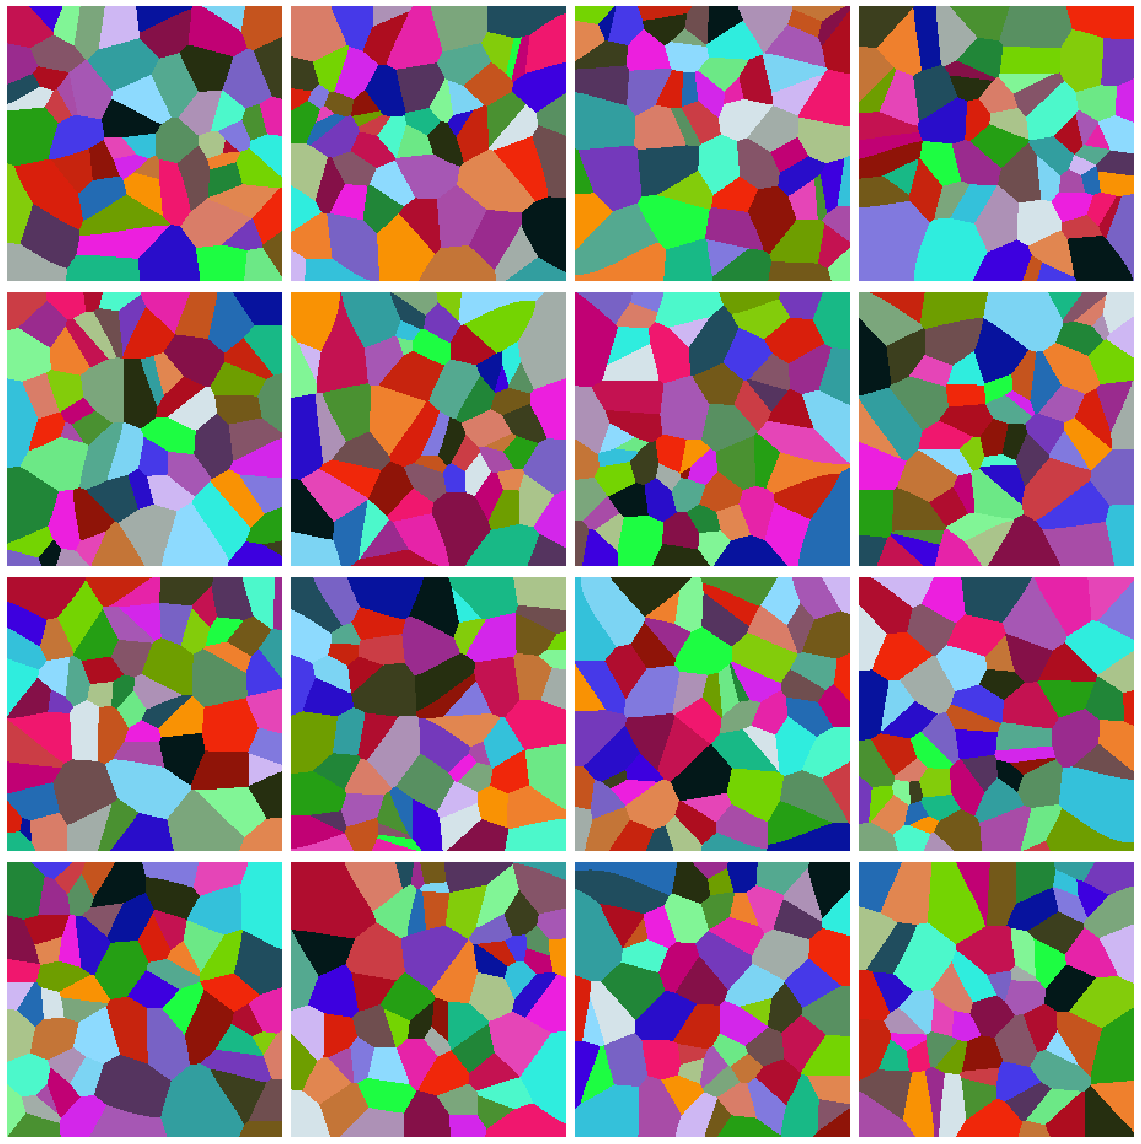

In [5]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt

# Create random colormap
cmap = mpl.colors.ListedColormap(torch.rand(256**2,3).numpy())

# Params = Image dimensions + No. clusters
B,H,W = 16,224,224
C = 64
dev = torch.device('cpu')

# Get image dimensions
N = B*H*W

# Unravel indices for coordinates
shape = torch.tensor([B,H,W,1], device=dev)[:,None]
coefs = shape[1:].flipud().cumprod(dim=0).flipud()
byx = torch.div(torch.arange(N, device=dev)[None], coefs, rounding_mode='trunc') % shape[:-1]

# Normalize coordinates
y, x = byx[1:] / torch.tensor([H,W], device=byx.device)[:,None]
b = byx[0]

# Sample random centroids
sy,sx = torch.rand(2,B,C,device=byx.device)

# Set bandwith / sigma for kernel
std = C/(H*W)**.5

# One liner gaussian kernels
def gauss1d(x): return x.div(std).pow_(2).neg_().exp_()
def gauss2d(x, y): return (gauss1d(x) + gauss1d(y)) / 2

# Compute L2 distance
l2 = gauss2d(y[:,None] - sy[b], x[:,None] - sx[b])

print(l2.shape)

# Plot argmax
fig, ax = plt.subplots(4,4,figsize=(16,16))
for i, a in enumerate(ax.flatten()):
    a.matshow(l2.argmax(-1).view(B,H,W)[i].cpu(), cmap=cmap)
    a.axis('off')

plt.tight_layout()

(1, 5)
(1, 5)
(1, 5)
(1, 5)
(1, 5)
(1, 7)
(1, 7)
(1, 5)
(1, 6)
(1, 5)
(1, 5)
(1, 5)


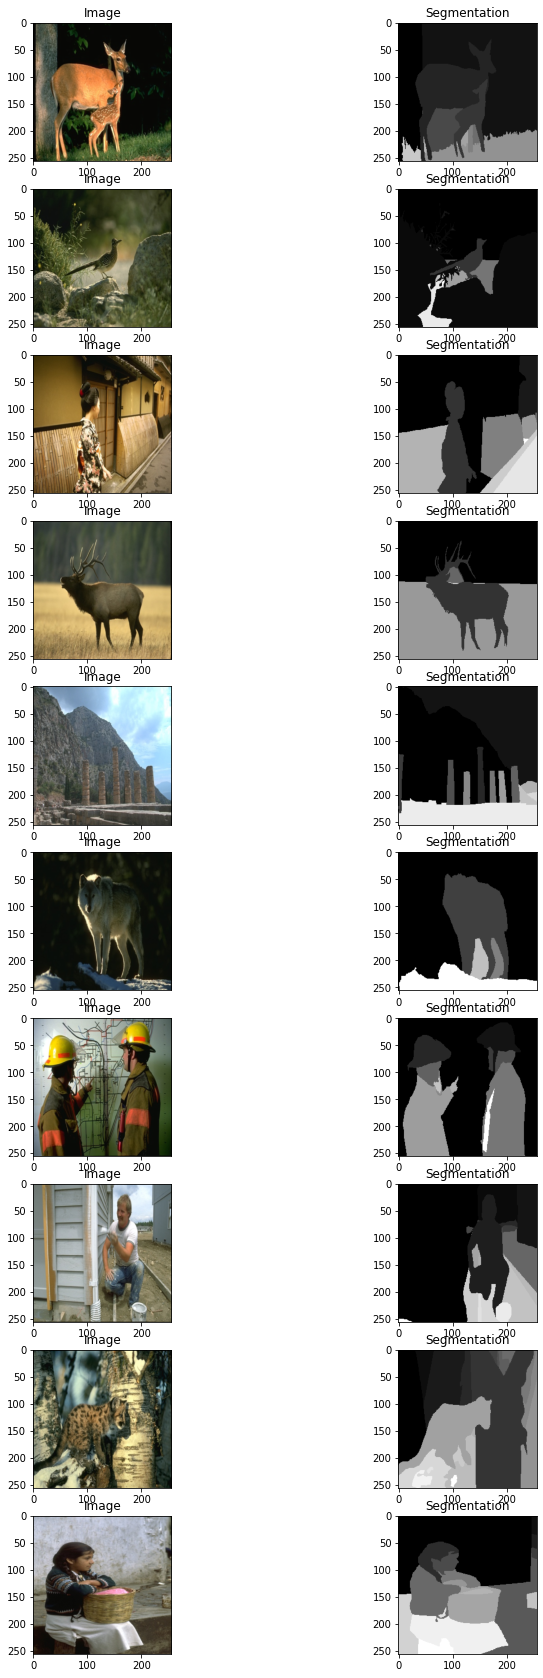

In [10]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

class BSDS500Dataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.images_dir = os.path.join(root_dir, 'images', split)
        self.ground_truth_dir = os.path.join(root_dir, 'ground_truth', split)
        self.image_files = [f for f in os.listdir(self.images_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_name = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        
        # Ensure the image is resized to a fixed size
        if self.transform:
            image = self.transform(image)
        
        # Load ground truth segmentation
        gt_name = os.path.join(self.ground_truth_dir, self.image_files[idx].replace('.jpg', '.mat'))
        gt_data = sio.loadmat(gt_name)
        ground_truth = gt_data['groundTruth'][0][0][0][0][1]

        
        #print(ground_truth)
        print(ground_truth.shape)
        # print(ground_truth[0, 0])
        # print(ground_truth[0, 0]['Segmentation'])
        # Extract the first segmentation from the nested structure
        segmentation = ground_truth
        
        # Check if segmentation has the shape (1, 1) and extract the data
        if isinstance(segmentation, np.ndarray) and segmentation.shape == (1, 1):
            segmentation = segmentation[0, 0]
        
        # Resize the segmentation mask to match the image size
        segmentation = Image.fromarray(segmentation)
        segmentation = segmentation.resize((256, 256), Image.NEAREST)
        
        # Convert the segmentation to int64 and ensure it's a 2D array
        segmentation = np.array(segmentation, dtype=np.int64)
        
        # Convert segmentation to a torch tensor
        segmentation = torch.tensor(segmentation, dtype=torch.long)
        
        return image, segmentation

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Set up the dataset
dataset = BSDS500Dataset(root_dir=r'D:\Data\BSDS500\data', split='train', transform=transform)

# Set up the DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

# Iterate through the DataLoader
def plot_images_with_segmentations(dataloader, num_images=4):
    images_shown = 0
    plt.figure(figsize=(12, num_images * 3))
    for i, (images, segmentations) in enumerate(dataloader):
        for j in range(images.shape[0]):
            if images_shown >= num_images:
                plt.show()
                return

            image = images[j].permute(1, 2, 0)  # Move channels to last dimension for plotting
            image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
            image = image.numpy()
            segmentation = segmentations[j].numpy()

            plt.subplot(num_images, 2, 2 * images_shown + 1)
            plt.imshow(image)
            plt.title('Image')

            plt.subplot(num_images, 2, 2 * images_shown + 2)
            plt.imshow(segmentation, cmap='gray')
            plt.title('Segmentation')

            images_shown += 1

    plt.show()

# Call the function to plot images and their segmentations
plot_images_with_segmentations(dataloader, num_images=10)